In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 14

from sklearn import linear_model, model_selection, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, f1_score, brier_score_loss
import xgboost
import scikitplot as skplt
from sklearn.model_selection import RandomizedSearchCV


pd.set_option('display.float_format', lambda x: '%3f' % x)

In [2]:
def plot_cm(y_true, y_pred):
    
    skplt.metrics.plot_confusion_matrix(
        y_true, 
        y_pred,
        figsize=(8,8))

In [3]:
train = pd.read_csv('../../data/train.csv')
test = pd.read_csv('../../data/test.csv')
validate = pd.read_csv('../../data/validate.csv')

In [4]:
train.drop('Unnamed: 0',axis=1,inplace=True)
test.drop('Unnamed: 0',axis=1,inplace=True)
validate.drop('Unnamed: 0',axis=1,inplace=True)

In [5]:
X= train.drop(["target",'eval_set'
               ,'user_unique_product_perc'
#                ,'user_product_last_time_product_ordered'
              ],axis=1)
y= train['target']

In [6]:
feature_cols = X.columns

In [7]:
X_train, X_test, y_train, y_test = (
    train_test_split(X,y, test_size=0.2, random_state=42))

In [8]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2258136, 19)
(564535, 19)
(2258136,)
(564535,)


In [9]:
rfreg = RandomForestClassifier(oob_score=True, random_state=1)
rfreg.fit(X_train, y_train)

RandomForestClassifier(oob_score=True, random_state=1)

In [10]:
pd.DataFrame(
    {'feature':feature_cols, 
     'importance':rfreg.feature_importances_}).sort_values(by='importance',ascending=False)

,feature,importance
18,user_product_last_time_product_ordered,0.801615
17,user_product_reorder_rate,0.072142
16,user_product_order_rate,0.051068
3,user_product_count,0.025977
5,user_product_last_order,0.023724
10,user_total_orders,0.006085
8,product_order_twice_ratio,0.002932
4,user_product_first_order,0.002749
12,user_avg_days_between_orders,0.002237
7,product_ordered_vol,0.001644


In [11]:
X_imputed_df = pd.DataFrame(X_train, columns = feature_cols)
X_imputed_df

,user_id,product_id,order_id,user_product_count,user_product_first_order,user_product_last_order,user_product_avg_basket_placement,product_ordered_vol,product_order_twice_ratio,user_total_products,user_total_orders,user_lifetime_days,user_avg_days_between_orders,user_max_time_between_orders,user_min_time_between_orders,user_avg_cart_size,user_product_order_rate,user_product_reorder_rate,user_product_last_time_product_ordered
1564843,50458,11782,2461845,1,9,9,9.000000,14720,0.902871,679,47,5997.000000,9.355694,30.000000,0.000000,14.446809,0.021277,0.025641,38
2070144,164494,21463,1673705,1,20,20,6.000000,4958,0.800371,213,23,2407.000000,11.461905,30.000000,2.000000,9.260870,0.043478,0.250000,3
192338,152208,23854,3175365,4,4,24,7.250000,2323,0.764553,454,24,6881.000000,15.567873,29.000000,6.000000,18.916667,0.166667,0.190476,0
1458804,157307,14627,1896081,5,40,48,11.800000,862,0.703057,520,49,3597.000000,7.310976,19.000000,2.000000,10.612245,0.102041,0.500000,1
1373972,52605,18087,2577294,1,15,15,12.000000,41,0.411765,256,32,1622.000000,6.385827,24.000000,0.000000,8.000000,0.031250,0.055556,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1692743,52124,19125,529461,5,2,8,7.000000,5538,0.790460,395,24,6148.000000,16.052219,30.000000,1.000000,16.458333,0.208333,0.217391,16
2356330,177611,5006,2266101,1,8,8,3.000000,738,0.151111,204,17,2655.000000,13.275000,30.000000,1.000000,12.000000,0.058824,0.100000,9
2229084,14699,42701,1681768,3,15,22,10.000000,27317,0.902534,369,26,3948.000000,11.184136,28.000000,0.000000,14.192308,0.115385,0.250000,4
2768307,69052,27344,2613230,1,2,2,23.000000,42652,1.043898,467,69,2455.000000,5.302376,30.000000,0.000000,6.768116,0.014493,0.014706,67


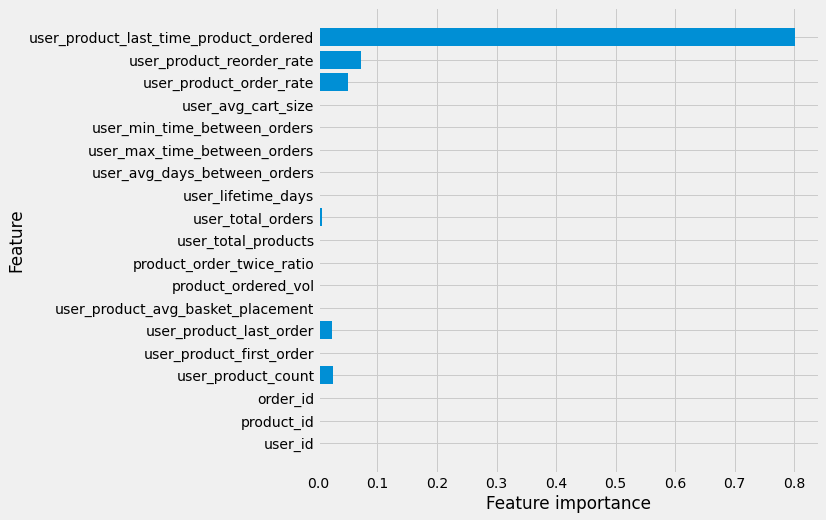

In [12]:
def plot_feature_importances(model):
    X_imputed_df = pd.DataFrame(X_train, columns = feature_cols)
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_imputed_df.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(rfreg)


In [13]:
print((rfreg.oob_score_))

0.9994114614885906


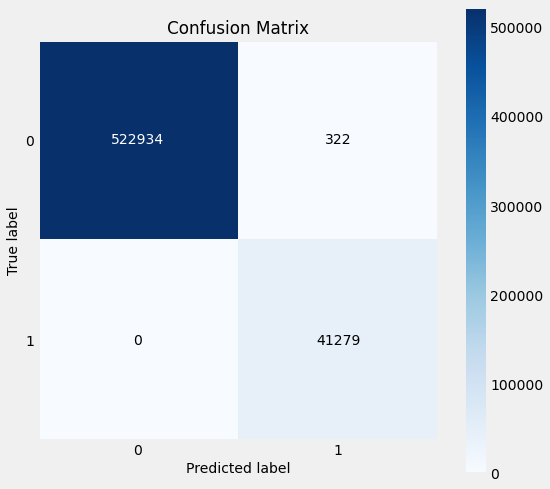

In [14]:
y_pred = rfreg.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_cm(y_test, y_pred)

In [15]:
rfreg.score(X_train, y_train)

1.0

In [16]:
rfreg.score(X_test, y_test)

0.9994296190670198

In [17]:
f1=f1_score(y_test,y_pred)
brier=brier_score_loss(y_test,y_pred)
auc=roc_auc_score(y_test,y_pred)

print(classification_report(y_test,y_pred))
print(f"f1:{f1:.5f},auc:{auc:.5f},loss_score:{brier:.5f}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523256
           1       0.99      1.00      1.00     41279

    accuracy                           1.00    564535
   macro avg       1.00      1.00      1.00    564535
weighted avg       1.00      1.00      1.00    564535

f1:0.99611,auc:0.99969,loss_score:0.00057


Results are very good but will try a random search to see if there are better params. Random search chosen because it's faster than grid search because not all parameter values are tried out- a fixed number of parameter settings is sampled from the specified distributions (n-iter). (jk keeps breaking my computer)

In [18]:
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree 
# max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
# max_depth.append(None)

# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth}
               
# rf_tune = RandomForestClassifier()
# rfreg_random = RandomizedSearchCV(estimator = rf_tune, param_distributions = random_grid, n_iter = 100, cv = 3, random_state=42)
# rfreg_random.fit(X_train, y_train)


In [19]:
# rfreg_random.best_params_

randomly changing up target vals and testing 

In [20]:
sample=train.sample(n=2000,random_state=42)

In [21]:
sample.target.value_counts()
sample.drop(['eval_set'],axis=1,inplace=True)
sample.head()

,user_id,product_id,target,order_id,user_product_count,user_product_first_order,user_product_last_order,user_product_avg_basket_placement,product_ordered_vol,product_order_twice_ratio,...,user_unique_product_perc,user_total_orders,user_lifetime_days,user_avg_days_between_orders,user_max_time_between_orders,user_min_time_between_orders,user_avg_cart_size,user_product_order_rate,user_product_reorder_rate,user_product_last_time_product_ordered
1430786,140433,20549,0,3414737,4,21,55,11.000000,5274,0.573775,...,0.427778,59,3631.000000,6.774254,23.000000,0.000000,9.152542,0.067797,0.102564,4
1893011,145537,20103,0,2282385,1,3,3,16.000000,85,0.476190,...,0.479167,19,4392.000000,13.682243,30.000000,4.000000,17.684211,0.052632,0.058824,16
459143,100660,21903,0,1206573,27,18,48,6.444444,249976,1.384341,...,0.195722,49,7245.000000,7.840909,15.000000,3.000000,19.081633,0.551020,0.843750,1
698152,203234,49517,0,807448,1,15,15,17.000000,3960,1.149776,...,0.400568,21,1657.000000,4.830904,9.000000,0.000000,16.761905,0.047619,0.142857,6
1896252,198768,9151,0,3263607,1,2,2,39.000000,77,0.594595,...,0.225440,27,12944.000000,13.814301,30.000000,1.000000,35.814815,0.037037,0.038462,25


In [22]:
import random
from random import randint, choice

In [23]:
# def rand_data(df, col):

new_targets=[]
np.random.seed(1)
col=sample['target']
for i in range(len(col)):
    k = random.randint(0, 1) 
    new_targets.append(k)
sample['new_target'] = new_targets
        

In [24]:
sample

,user_id,product_id,target,order_id,user_product_count,user_product_first_order,user_product_last_order,user_product_avg_basket_placement,product_ordered_vol,product_order_twice_ratio,...,user_total_orders,user_lifetime_days,user_avg_days_between_orders,user_max_time_between_orders,user_min_time_between_orders,user_avg_cart_size,user_product_order_rate,user_product_reorder_rate,user_product_last_time_product_ordered,new_target
1430786,140433,20549,0,3414737,4,21,55,11.000000,5274,0.573775,...,59,3631.000000,6.774254,23.000000,0.000000,9.152542,0.067797,0.102564,4,1
1893011,145537,20103,0,2282385,1,3,3,16.000000,85,0.476190,...,19,4392.000000,13.682243,30.000000,4.000000,17.684211,0.052632,0.058824,16,1
459143,100660,21903,0,1206573,27,18,48,6.444444,249976,1.384341,...,49,7245.000000,7.840909,15.000000,3.000000,19.081633,0.551020,0.843750,1,0
698152,203234,49517,0,807448,1,15,15,17.000000,3960,1.149776,...,21,1657.000000,4.830904,9.000000,0.000000,16.761905,0.047619,0.142857,6,1
1896252,198768,9151,0,3263607,1,2,2,39.000000,77,0.594595,...,27,12944.000000,13.814301,30.000000,1.000000,35.814815,0.037037,0.038462,25,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795039,172793,32177,0,630046,2,91,92,4.500000,10709,0.781812,...,100,4215.000000,3.247304,8.000000,0.000000,13.120000,0.020000,0.200000,8,1
1837376,180156,31766,0,2973926,4,53,77,19.000000,8722,1.039292,...,81,4948.000000,5.807512,24.000000,0.000000,10.925926,0.049383,0.137931,4,1
145795,205341,726,1,2413932,2,41,42,12.500000,431,0.692308,...,42,4077.000000,8.901747,30.000000,0.000000,11.000000,0.047619,1.000000,0,1
1672905,160706,7175,0,279217,1,15,15,1.000000,12954,0.898999,...,20,3447.000000,15.884793,30.000000,4.000000,11.650000,0.050000,0.166667,5,0


In [26]:
#check against sample1 set

X_sam = sample.drop(["target",'new_target','user_unique_product_perc'],axis=1)
y_sam = sample['new_target']

# rfreg.score(X_val,y_val)
y_pred = rfreg.predict(X_sam)

f1=f1_score(y_sam,y_pred)
brier=brier_score_loss(y_sam,y_pred)
auc=roc_auc_score(y_sam,y_pred)

print(classification_report(y_sam,y_pred))
print(f"f1:{f1:.5f},auc:{auc:.5f},loss_score:{brier:.5f}")

              precision    recall  f1-score   support

           0       0.50      0.91      0.65      1011
           1       0.47      0.08      0.13       989

    accuracy                           0.50      2000
   macro avg       0.49      0.50      0.39      2000
weighted avg       0.49      0.50      0.39      2000

f1:0.13368,auc:0.49640,loss_score:0.49900


Changing up feature vals and target

In [27]:
def gen_random_float(stop):
    random_float_list = []
    for i in range(0, stop):
        x = random.uniform(0.0, 1.0)
        random_float_list.append(x)
        
    return random_float_list

In [28]:
np.array(gen_random_float(5))

array([0.90433407, 0.09467518, 0.0853187 , 0.67733556, 0.03454489])

In [29]:
np.random.seed(1)
random_data =pd.DataFrame({"user_product_last_time_product_ordered_new":np.random.choice(range(4,150), 2000, replace=True),
                 "user_product_reorder_rate_new":np.array(gen_random_float(2000)),
                 "product_ordered_vol_new":np.random.choice(range(1,500000), 2000, replace=True)
                   }) 


In [30]:
sample2=train.sample(n=2000,random_state=52)
sample2.target.value_counts()
sample2.reset_index(inplace=True)
sample2.drop('index', axis=1,inplace=True)
sample2


,user_id,product_id,eval_set,target,order_id,user_product_count,user_product_first_order,user_product_last_order,user_product_avg_basket_placement,product_ordered_vol,...,user_unique_product_perc,user_total_orders,user_lifetime_days,user_avg_days_between_orders,user_max_time_between_orders,user_min_time_between_orders,user_avg_cart_size,user_product_order_rate,user_product_reorder_rate,user_product_last_time_product_ordered
0,183237,41290,prior,0,808711,5,1,15,3.800000,20247,...,0.564516,26,4472.000000,12.319559,30.000000,2.000000,14.307692,0.192308,0.192308,11
1,28287,44661,prior,0,2841330,1,12,12,1.000000,9591,...,0.712329,17,833.000000,12.432836,30.000000,1.000000,4.294118,0.058824,0.166667,5
2,173504,3645,train,1,3270640,4,5,18,13.750000,298,...,0.474227,18,5638.000000,19.576389,30.000000,1.000000,16.166667,0.222222,0.285714,0
3,121581,19677,prior,0,3112541,1,6,6,6.000000,15110,...,0.402655,24,3244.000000,15.980296,30.000000,5.000000,9.416667,0.041667,0.052632,18
4,87247,39693,prior,0,1673473,1,8,8,21.000000,2934,...,0.202936,43,9393.000000,8.290380,25.000000,6.000000,26.930233,0.023256,0.027778,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,52550,24852,train,1,288849,33,6,43,6.757576,489122,...,0.093780,43,7429.000000,7.276200,14.000000,3.000000,24.302326,0.767442,0.868421,0
1996,129962,4792,prior,0,1838479,1,7,7,12.000000,4846,...,0.463476,36,4051.000000,10.716931,30.000000,0.000000,11.027778,0.027778,0.033333,29
1997,199776,9000,prior,0,2625867,1,18,18,17.000000,2210,...,0.399220,34,8055.000000,10.974114,30.000000,2.000000,22.617647,0.029412,0.058824,16
1998,81119,43961,prior,0,403399,1,27,27,15.000000,57037,...,0.295533,33,6604.000000,11.813953,22.000000,4.000000,17.636364,0.030303,0.142857,6


In [31]:
random_data

,user_product_last_time_product_ordered_new,user_product_reorder_rate_new,product_ordered_vol_new
0,41,0.053528,255864
1,144,0.941877,477586
2,76,0.406406,352740
3,141,0.279906,362145
4,137,0.983060,231646
...,...,...,...
1995,124,0.462798,70963
1996,121,0.680610,286178
1997,25,0.101596,181469
1998,17,0.729844,355606


In [32]:
sample2_new = pd.concat([sample2,random_data], axis=1)
sample2_new

# del sample2_new

,user_id,product_id,eval_set,target,order_id,user_product_count,user_product_first_order,user_product_last_order,user_product_avg_basket_placement,product_ordered_vol,...,user_avg_days_between_orders,user_max_time_between_orders,user_min_time_between_orders,user_avg_cart_size,user_product_order_rate,user_product_reorder_rate,user_product_last_time_product_ordered,user_product_last_time_product_ordered_new,user_product_reorder_rate_new,product_ordered_vol_new
0,183237,41290,prior,0,808711,5,1,15,3.800000,20247,...,12.319559,30.000000,2.000000,14.307692,0.192308,0.192308,11,41,0.053528,255864
1,28287,44661,prior,0,2841330,1,12,12,1.000000,9591,...,12.432836,30.000000,1.000000,4.294118,0.058824,0.166667,5,144,0.941877,477586
2,173504,3645,train,1,3270640,4,5,18,13.750000,298,...,19.576389,30.000000,1.000000,16.166667,0.222222,0.285714,0,76,0.406406,352740
3,121581,19677,prior,0,3112541,1,6,6,6.000000,15110,...,15.980296,30.000000,5.000000,9.416667,0.041667,0.052632,18,141,0.279906,362145
4,87247,39693,prior,0,1673473,1,8,8,21.000000,2934,...,8.290380,25.000000,6.000000,26.930233,0.023256,0.027778,35,137,0.983060,231646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,52550,24852,train,1,288849,33,6,43,6.757576,489122,...,7.276200,14.000000,3.000000,24.302326,0.767442,0.868421,0,124,0.462798,70963
1996,129962,4792,prior,0,1838479,1,7,7,12.000000,4846,...,10.716931,30.000000,0.000000,11.027778,0.027778,0.033333,29,121,0.680610,286178
1997,199776,9000,prior,0,2625867,1,18,18,17.000000,2210,...,10.974114,30.000000,2.000000,22.617647,0.029412,0.058824,16,25,0.101596,181469
1998,81119,43961,prior,0,403399,1,27,27,15.000000,57037,...,11.813953,22.000000,4.000000,17.636364,0.030303,0.142857,6,17,0.729844,355606


In [33]:
new_targs=[]
np.random.seed(2)
col=sample2_new['target']
for i in range(len(col)):
    k = random.randint(0, 1) 
    new_targs.append(k)


In [34]:
sample2_new['new_target'] = new_targs

In [35]:
sample2_new.new_target.value_counts()

0    1037
1     963
Name: new_target, dtype: int64

In [36]:
sample2_new.drop(['user_product_last_time_product_ordered','user_product_reorder_rate','product_ordered_vol'],axis=1,inplace=True)

sample2_new.rename(columns={'user_product_last_time_product_ordered_new':'user_product_last_time_product_ordered',
                        'user_product_reorder_rate_new':'user_product_reorder_rate',
                        'product_ordered_vol_new':'product_ordered_vol'},inplace=True)

sample2_new


,user_id,product_id,eval_set,target,order_id,user_product_count,user_product_first_order,user_product_last_order,user_product_avg_basket_placement,product_order_twice_ratio,...,user_lifetime_days,user_avg_days_between_orders,user_max_time_between_orders,user_min_time_between_orders,user_avg_cart_size,user_product_order_rate,user_product_last_time_product_ordered,user_product_reorder_rate,product_ordered_vol,new_target
0,183237,41290,prior,0,808711,5,1,15,3.800000,1.015186,...,4472.000000,12.319559,30.000000,2.000000,14.307692,0.192308,41,0.053528,255864,0
1,28287,44661,prior,0,2841330,1,12,12,1.000000,0.838377,...,833.000000,12.432836,30.000000,1.000000,4.294118,0.058824,144,0.941877,477586,1
2,173504,3645,train,1,3270640,4,5,18,13.750000,0.698630,...,5638.000000,19.576389,30.000000,1.000000,16.166667,0.222222,76,0.406406,352740,1
3,121581,19677,prior,0,3112541,1,6,6,6.000000,1.101189,...,3244.000000,15.980296,30.000000,5.000000,9.416667,0.041667,141,0.279906,362145,0
4,87247,39693,prior,0,1673473,1,8,8,21.000000,0.623156,...,9393.000000,8.290380,25.000000,6.000000,26.930233,0.023256,137,0.983060,231646,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,52550,24852,train,1,288849,33,6,43,6.757576,1.546487,...,7429.000000,7.276200,14.000000,3.000000,24.302326,0.767442,124,0.462798,70963,1
1996,129962,4792,prior,0,1838479,1,7,7,12.000000,0.905734,...,4051.000000,10.716931,30.000000,0.000000,11.027778,0.027778,121,0.680610,286178,1
1997,199776,9000,prior,0,2625867,1,18,18,17.000000,0.464443,...,8055.000000,10.974114,30.000000,2.000000,22.617647,0.029412,25,0.101596,181469,0
1998,81119,43961,prior,0,403399,1,27,27,15.000000,1.081007,...,6604.000000,11.813953,22.000000,4.000000,17.636364,0.030303,17,0.729844,355606,0


In [37]:
X_sam2 = sample2_new.drop(["target",'new_target','eval_set','user_unique_product_perc'],axis=1)
y_sam2 = sample2_new['target']

# rfreg.score(X_val,y_val)
y_pred = rfreg.predict(X_sam2)

f1=f1_score(y_sam2,y_pred)
brier=brier_score_loss(y_sam2,y_pred)
auc=roc_auc_score(y_sam2,y_pred)

print(classification_report(y_sam2,y_pred))
print(f"f1:{f1:.5f},auc:{auc:.5f},loss_score:{brier:.5f}")

              precision    recall  f1-score   support

           0       0.93      1.00      0.97      1865
           1       0.00      0.00      0.00       135

    accuracy                           0.93      2000
   macro avg       0.47      0.50      0.48      2000
weighted avg       0.87      0.93      0.90      2000

f1:0.00000,auc:0.50000,loss_score:0.06750


/Users/tiffany.chen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Validation set performance

In [38]:
#check against validation set

X_val = validate.drop(["target",'eval_set','user_unique_product_perc'],axis=1)
y_val = validate['target']

# rfreg.score(X_val,y_val)
y_pred = rfreg.predict(X_val)

f1=f1_score(y_val,y_pred)
brier=brier_score_loss(y_val,y_pred)
auc=roc_auc_score(y_val,y_pred)

print(classification_report(y_val,y_pred))
print(f"f1:{f1:.5f},auc:{auc:.5f},loss_score:{brier:.5f}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    874179
           1       0.99      1.00      1.00     69666

    accuracy                           1.00    943845
   macro avg       1.00      1.00      1.00    943845
weighted avg       1.00      1.00      1.00    943845

f1:0.99556,auc:0.99964,loss_score:0.00066


### Test Set Performance

In [39]:
#check against validation set

X_tst = test.drop(["target",'eval_set','user_unique_product_perc'],axis=1)
y_tst = test['target']

# rfreg.score(X_val,y_val)
y_pred = rfreg.predict(X_tst)

f1=f1_score(y_tst,y_pred)
brier=brier_score_loss(y_tst,y_pred)
auc=roc_auc_score(y_tst,y_pred)

print(classification_report(y_tst,y_pred))
print(f"f1:{f1:.5f},auc:{auc:.5f},loss_score:{brier:.5f}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    859901
           1       0.99      1.00      0.99     69835

    accuracy                           1.00    929736
   macro avg       0.99      1.00      1.00    929736
weighted avg       1.00      1.00      1.00    929736

f1:0.99493,auc:0.99959,loss_score:0.00077


## XGBoost

In [40]:
gbm = xgboost.XGBClassifier()
gbm.fit(X_train, y_train)
training_pred = gbm.predict(X_train)
y_pred = gbm.predict(X_test)
training_accuracy = accuracy_score(y_train, training_pred)
test_accuracy = accuracy_score(y_test, y_pred)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(test_accuracy * 100))

Training Accuracy: 99.97%
Validation accuracy: 99.96%


In [41]:
f1=f1_score(y_test,y_pred)
brier=brier_score_loss(y_test,y_pred)
auc=roc_auc_score(y_test,y_pred)

print(classification_report(y_test,y_pred))
print(f"f1:{f1:.5f},auc:{auc:.5f},loss_score:{brier:.5f}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523256
           1       0.99      1.00      1.00     41279

    accuracy                           1.00    564535
   macro avg       1.00      1.00      1.00    564535
weighted avg       1.00      1.00      1.00    564535

f1:0.99733,auc:0.99979,loss_score:0.00039


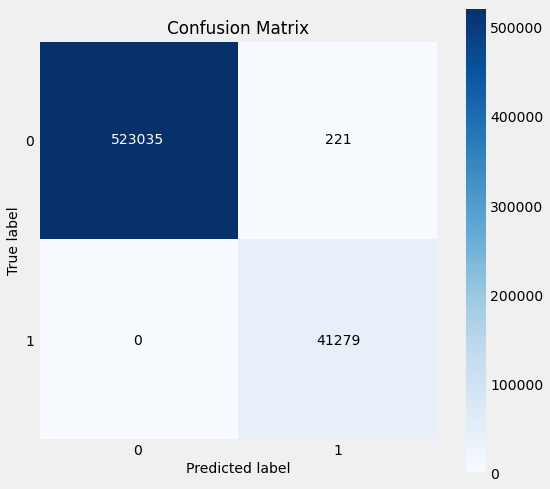

In [42]:
y_pred = gbm.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_cm(y_test, y_pred)

(overwritten) -- tested model without user_unique_product_perc feature, which was ranked first in feature importance because intuitively, it didn't make much sense in predicting reordering. After doing so, the model's performance was still very good. f1:0.99655,auc:0.99968,loss_score:0.00051

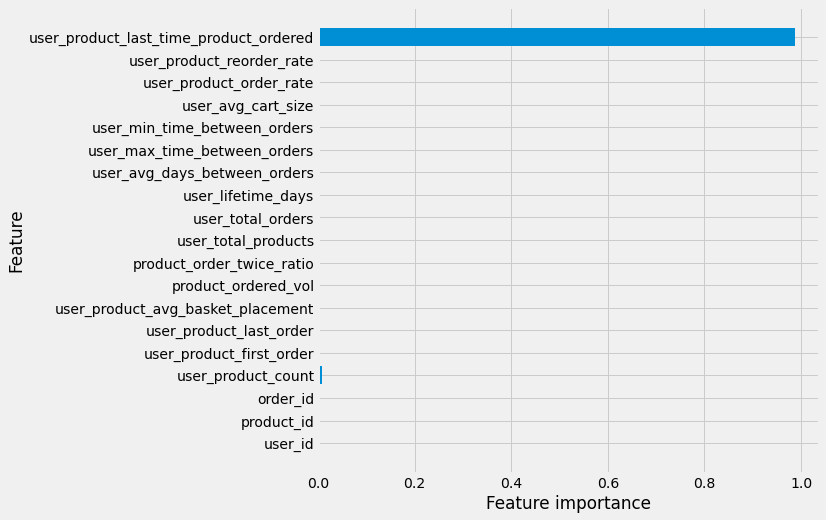

In [43]:
plot_feature_importances(gbm)

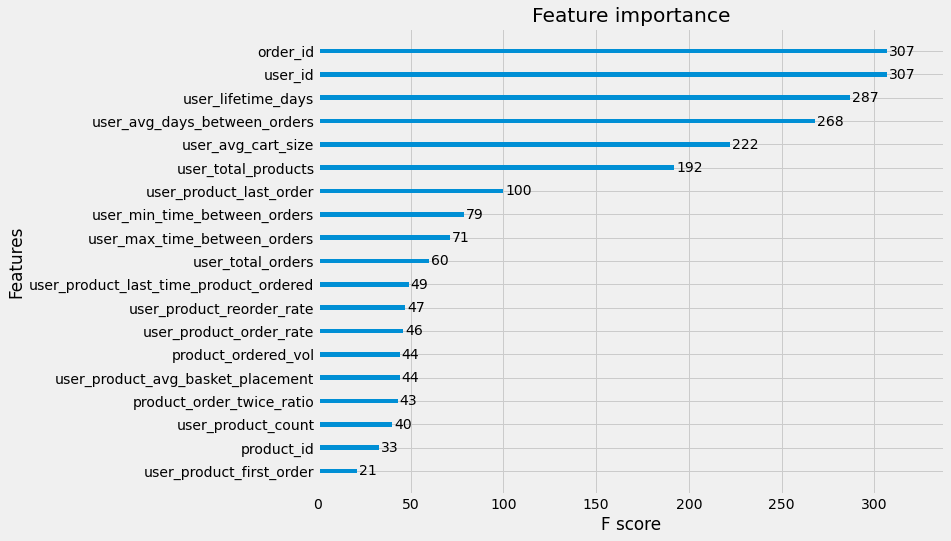

In [44]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(gbm)
pyplot.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    874179
           1       0.99      1.00      1.00     69666

    accuracy                           1.00    943845
   macro avg       1.00      1.00      1.00    943845
weighted avg       1.00      1.00      1.00    943845

f1:0.99545,auc:0.99958,loss_score:0.00067


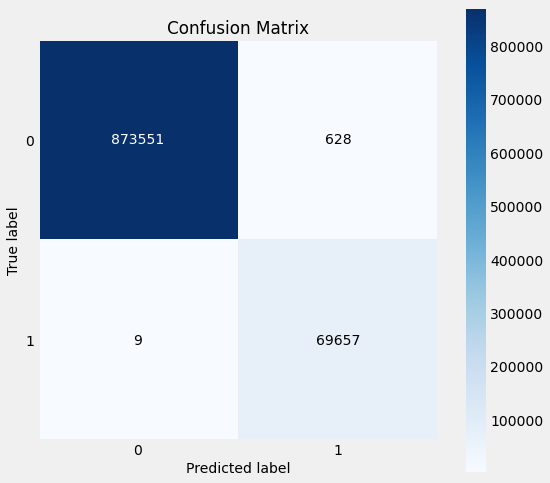

In [45]:
#check against validation set

# X_val = validate.drop(["target",'eval_set'],axis=1)
# y_val = validate['target']

y_pred = gbm.predict(X_val)

f1=f1_score(y_val,y_pred)
brier=brier_score_loss(y_val,y_pred)
auc=roc_auc_score(y_val,y_pred)

print(classification_report(y_val,y_pred))
print(f"f1:{f1:.5f},auc:{auc:.5f},loss_score:{brier:.5f}")

plot_cm(y_val, y_pred)

In [47]:
depths = [5,10,15]
n_estimators = [40,140,240,340]
rates = [.05,.1,.2]

for learning_rate in rates:
    for n_tree in n_estimators:
        for depth in depths:
            gbm = xgboost.XGBRegressor(objective='binary:logistic',
                            max_depth=depth,
                            learning_rate=learning_rate,
                            n_estimators=n_tree,
                            subsample=.8,
                            colsample_bytree=.8)

            gbm.fit(X_train, y_train,
                eval_set=[(X_val, y_val)],
                eval_metric='rmse',
                early_stopping_rounds=2, verbose=False)

In [48]:
gbm = xgboost.XGBClassifier(objective='binary:logistic',
                            max_depth=10,
                            learning_rate=.25,
                            n_estimators=240,
                            subsample=.8,
                            colsample_bytree=.8)
gbm.fit(X_train, y_train,
                eval_set=[(X_test, y_test)],
                eval_metric='auc',
                early_stopping_rounds=2)

training_pred = gbm.predict(X_train)
y_pred = gbm.predict(X_test)
training_accuracy = accuracy_score(y_train, training_pred)
test_accuracy = accuracy_score(y_test, y_pred)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(test_accuracy * 100))

[0]	validation_0-auc:0.99977
Will train until validation_0-auc hasn't improved in 2 rounds.
[1]	validation_0-auc:0.99963
[2]	validation_0-auc:0.99955
Stopping. Best iteration:
[0]	validation_0-auc:0.99977

Training Accuracy: 99.93%
Validation accuracy: 99.93%


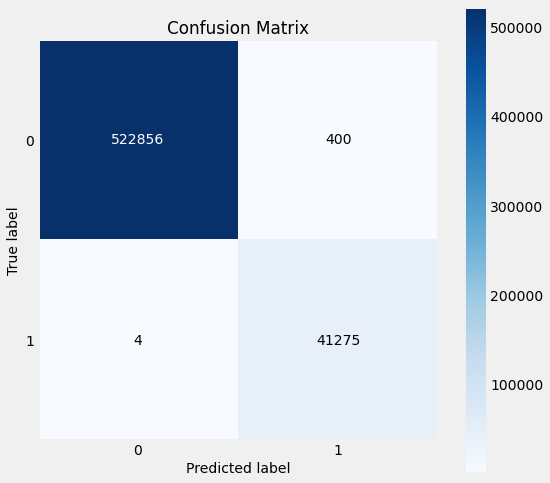

In [49]:
y_pred = gbm.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_cm(y_test, y_pred)

In [50]:
f1=f1_score(y_test,y_pred)
brier=brier_score_loss(y_test,y_pred)
auc=roc_auc_score(y_test,y_pred)

print(classification_report(y_test,y_pred))
print(f"f1:{f1:.5f},auc:{auc:.5f},loss_score:{brier:.5f}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523256
           1       0.99      1.00      1.00     41279

    accuracy                           1.00    564535
   macro avg       1.00      1.00      1.00    564535
weighted avg       1.00      1.00      1.00    564535

f1:0.99513,auc:0.99957,loss_score:0.00072


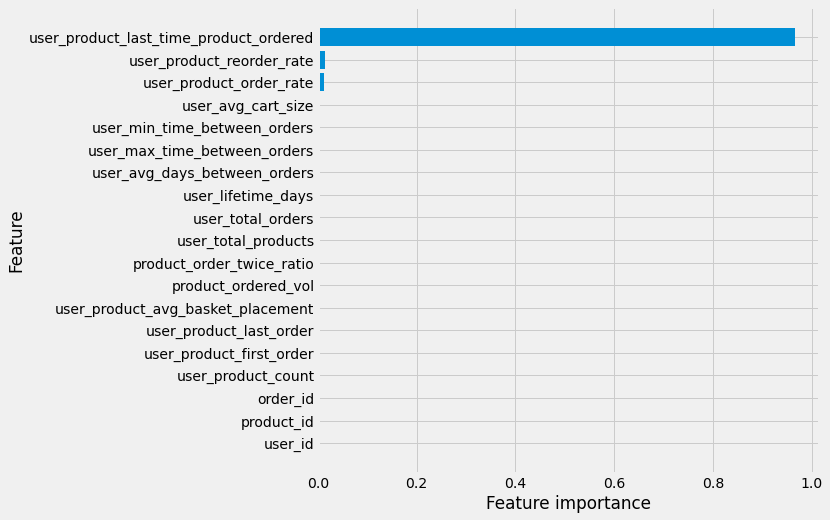

In [51]:
plot_feature_importances(gbm)

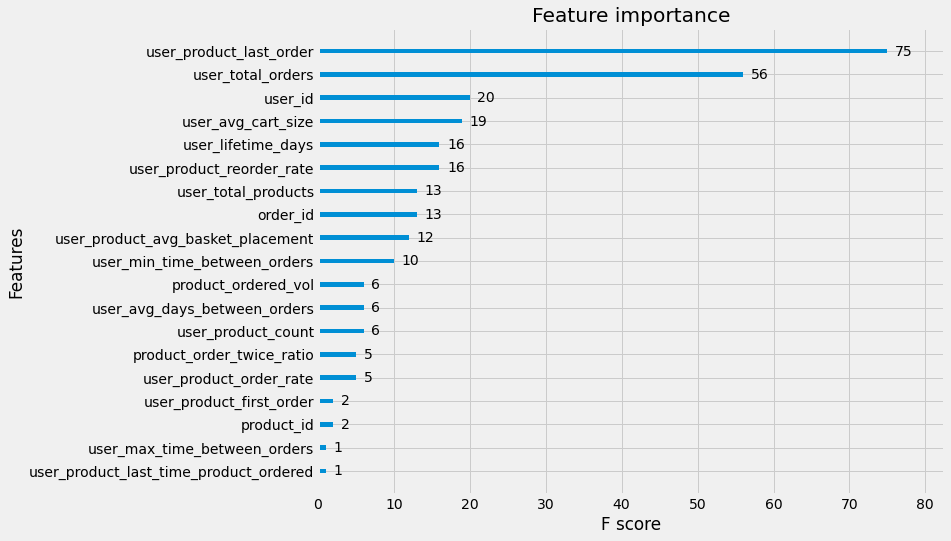

In [52]:
plot_importance(gbm)
pyplot.show()